In [32]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import math
import json

import torch
import numpy as np

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.scripts.eval import eval_setup

# Implementation

In [33]:
config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

VanillaDataManager()

In [52]:
dataparser_transforms_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")

with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

In [68]:
data_transform_matrix = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0,
    "k2": 0,
    "k3": 0,
    "k4": 0,
    "p1": 0,
    "p2": 0,
    "is_fisheye": False,
    "cx": 256.0,
    "cy": 256.0,
    "w": 512,
    "h": 512,
    "aabb_scale": 32,
}

# print(f"Matrix before transformation:\n {data_transform_matrix}")
# data_transform_matrix[:3, 3] /= 512
# print(f"Matrix after transformation:\n {data_transform_matrix}")

In [74]:
final_matrix = np.dot(dataparser_matrix, data_transform_matrix)
final_matrix[:3, 3] = final_matrix[:3, 3] * dataparser_scale
final_matrix

# should look like this:
# actual_transform_matrix = np.array([
#     [-0.2205035537481308, -0.21815498173236847, -0.9506769180297852, -0.11759857088327408],
#     [-0.9667345285415649, 0.17840947210788727, 0.1832878142595291, 0.23202396929264069],
#     [0.129624605178833, 0.9594677686691284, -0.2502378523349762, -0.26915040612220764],
#     [0, 0, 0, 1]
# ])

array([[-0.22050356, -0.21815497, -0.95067694, -0.1175986 ],
       [-0.96673455,  0.17840947,  0.18328782,  0.23202395],
       [ 0.12962461,  0.9594678 , -0.25023786, -0.2691504 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

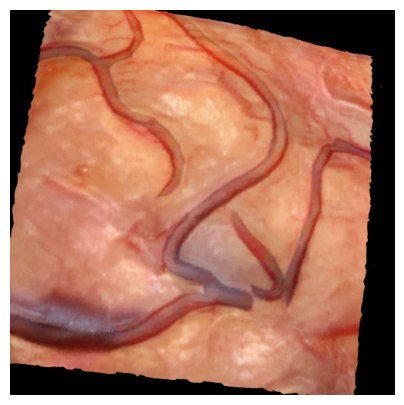

In [70]:
camera = Cameras(
    camera_to_worlds=torch.tensor(final_matrix[:3, :4], dtype=torch.float32),
    fx=camera_params["fl_x"],
    fy=camera_params["fl_y"],
    cx=camera_params["cx"],
    cy=camera_params["cy"],
    camera_type=CameraType.PERSPECTIVE,
    height=camera_params["h"],
    width=camera_params["w"],

)

with torch.no_grad():
    outputs = nerf_model.get_outputs_for_camera(camera)
    generated_rgb = outputs["rgb"].cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(generated_rgb)
plt.axis('off')
plt.show()

### Generate the image

In [8]:
generated_image = Image.fromarray((generated_rgb[0] * 255).astype(np.uint8))
generated_image.save("generated_image.png")

# Misc

In [ ]:
def extract_translation_rotation(transform_matrix):
    def rotation_matrix_to_euler_angles(R):
        sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
        singular = sy < 1e-6

        if not singular:
            x = math.atan2(R[2, 1], R[2, 2])
            y = math.atan2(-R[2, 0], sy)
            z = math.atan2(R[1, 0], R[0, 0])
        else:
            x = math.atan2(-R[1, 2], R[1, 1])
            y = math.atan2(-R[2, 0], sy)
            z = 0

        return np.array([x, y, z])

    # Extract translation
    translation = transform_matrix[:3, 3]

    # Extract rotation matrix
    rotation_matrix = transform_matrix[:3, :3]

    # Get Euler angles
    euler_angles = rotation_matrix_to_euler_angles(rotation_matrix)

    # Convert to degrees
    euler_angles_deg = np.degrees(euler_angles)

    return translation, euler_angles_deg


translation, rotation = extract_translation_rotation(transform_matrix)

print("Translations (x, y, z):", translation)
print("Rotation angles (in degrees):")
print("Roll (x-axis):", rotation[0])
print("Pitch (y-axis):", rotation[1])
print("Yaw (z-axis):", rotation[2])

In [211]:
from pathlib import Path

config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/nerfacto/2024-08-20_111705/config.yml")

# Read and print the content of the file
with open(config_path, 'r') as file:
    content = file.read()
    print(content)

!!python/object:nerfstudio.engine.trainer.TrainerConfig
_target: !!python/name:nerfstudio.engine.trainer.Trainer ''
data: &id003 !!python/object/apply:pathlib.PosixPath
- data
- datasets
- 0_065_cat5_2.0
experiment_name: 0_065_cat5_2
gradient_accumulation_steps: {}
load_checkpoint: null
load_config: null
load_dir: null
load_scheduler: true
load_step: null
log_gradients: false
logging: !!python/object:nerfstudio.configs.base_config.LoggingConfig
  local_writer: !!python/object:nerfstudio.configs.base_config.LocalWriterConfig
    _target: !!python/name:nerfstudio.utils.writer.LocalWriter ''
    enable: true
    max_log_size: 10
    stats_to_track: !!python/tuple
    - !!python/object/apply:nerfstudio.utils.writer.EventName
      - Train Iter (time)
    - !!python/object/apply:nerfstudio.utils.writer.EventName
      - Train Rays / Sec
    - !!python/object/apply:nerfstudio.utils.writer.EventName
      - Test PSNR
    - !!python/object/apply:nerfstudio.utils.writer.EventName
      - Vis Ra